# ROC analysis


In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mc

#from statannotations.Annotator import Annotator
import allen_utils as allen


In [2]:
FIGURE_PATH = r'M:\analysis\Axel_Bisi\results\roc_analysis'

# Load ROC data for all mice 
#### Find all files:

In [3]:
mouse_info_path = os.path.join('\\\\sv-nas1.rcp.epfl.ch', 'Petersen-Lab', 'analysis','Axel_Bisi', 'mice_info')
mouse_info_df = pd.read_excel(os.path.join(mouse_info_path, 'mouse_reference_weight.xlsx')) # load mouse info file

data_path = os.path.join('\\\\sv-nas1.rcp.epfl.ch', 'Petersen-Lab', 'analysis', 'Axel_Bisi', 'results')
roc_results_files = glob.glob(os.path.join(data_path, '**', '*_roc_results.csv'), recursive=True) # find all roc results files


In [4]:
print('Number of ROC files', len(roc_results_files))

Number of ROC files 42


#### Check out content of results:

In [7]:
roc_df = pd.concat([pd.read_csv(f) for f in roc_results_files], ignore_index=True) # concatenate all roc results files
# Use the reward group column of mouse_info_df to add the reward group to roc_df
roc_df = roc_df.merge(mouse_info_df[['mouse_id', 'reward_group']], on='mouse_id', how='left')
print('Present mice:', roc_df['mouse_id'].unique(), 'Number of mice', roc_df['mouse_id'].nunique(), 'per reward group',  roc_df.groupby('reward_group')['mouse_id'].nunique()) 
print(roc_df['analysis_type'].unique())

excluded_mice = ['AB077','AB082']
roc_df = roc_df[~roc_df['mouse_id'].isin(excluded_mice)]

Present mice: ['AB077' 'AB080' 'AB082' 'AB085' 'AB086' 'AB087' 'AB092' 'AB093' 'AB094'
 'AB095' 'AB102' 'AB104' 'AB107' 'AB116' 'AB117' 'AB119' 'AB120' 'AB121'
 'AB122' 'AB123' 'AB124' 'AB125' 'AB126' 'AB127' 'AB128' 'AB129' 'AB130'
 'AB131' 'AB132' 'AB133' 'AB134' 'AB136' 'AB138' 'AB139' 'AB140' 'AB141'
 'AB142' 'AB143' 'AB145' 'AB147' 'AB149' 'AB150'] Number of mice 42 per reward group reward_group
R+    24
R-    18
Name: mouse_id, dtype: int64
['whisker_active' 'auditory_active' 'wh_vs_aud_active' 'spontaneous_licks'
 'whisker_passive_pre' 'whisker_passive_post'
 'whisker_pre_vs_post_learning' 'auditory_passive_pre'
 'auditory_passive_post' 'auditory_pre_vs_post_learning'
 'wh_vs_aud_passive_pre' 'wh_vs_aud_passive_post'
 'wh_vs_aud_pre_vs_post_learning']


In [8]:
print('Analysis types', roc_df['analysis_type'].unique())

Analysis types ['whisker_active' 'auditory_active' 'wh_vs_aud_active' 'spontaneous_licks'
 'whisker_passive_pre' 'whisker_passive_post'
 'whisker_pre_vs_post_learning' 'auditory_passive_pre'
 'auditory_passive_post' 'auditory_pre_vs_post_learning'
 'wh_vs_aud_passive_pre' 'wh_vs_aud_passive_post'
 'wh_vs_aud_pre_vs_post_learning']


# Data selection
#### Process area names

In [9]:
#roc_df = create_area_custom_column(roc_df)
roc_df = allen.create_area_custom_column(roc_df)

In [10]:
roc_df.columns

Index(['mouse_id', 'unit_id', 'cluster_id', 'firing_rate', 'ccf_acronym',
       'ccf_name', 'ccf_parent_acronym', 'ccf_parent_id', 'ccf_parent_name',
       'analysis_type', 'area', 'auc', 'selectivity', 'fpr', 'tpr',
       'thresholds', 'significant', 'direction', 'p_value', 'p_value_to_show',
       'reward_group', 'area_acronym_custom'],
      dtype='object')

#### Check out number of neurons, total

In [11]:
df_counts = roc_df.groupby(['analysis_type'])['area_acronym_custom'].value_counts().reset_index()
df_counts = df_counts[df_counts.analysis_type=='whisker_active']
df_counts

,analysis_type,area_acronym_custom,count
555,whisker_active,MOs,4220
556,whisker_active,CP,3651
557,whisker_active,ORB,1753
558,whisker_active,SSs,1448
559,whisker_active,MOp,1311
...,...,...,...
613,whisker_active,LA,8
614,whisker_active,TEa,6
615,whisker_active,VISC,4
616,whisker_active,SEZ,3


#### Plot number of neurons to compare with ROC analyses

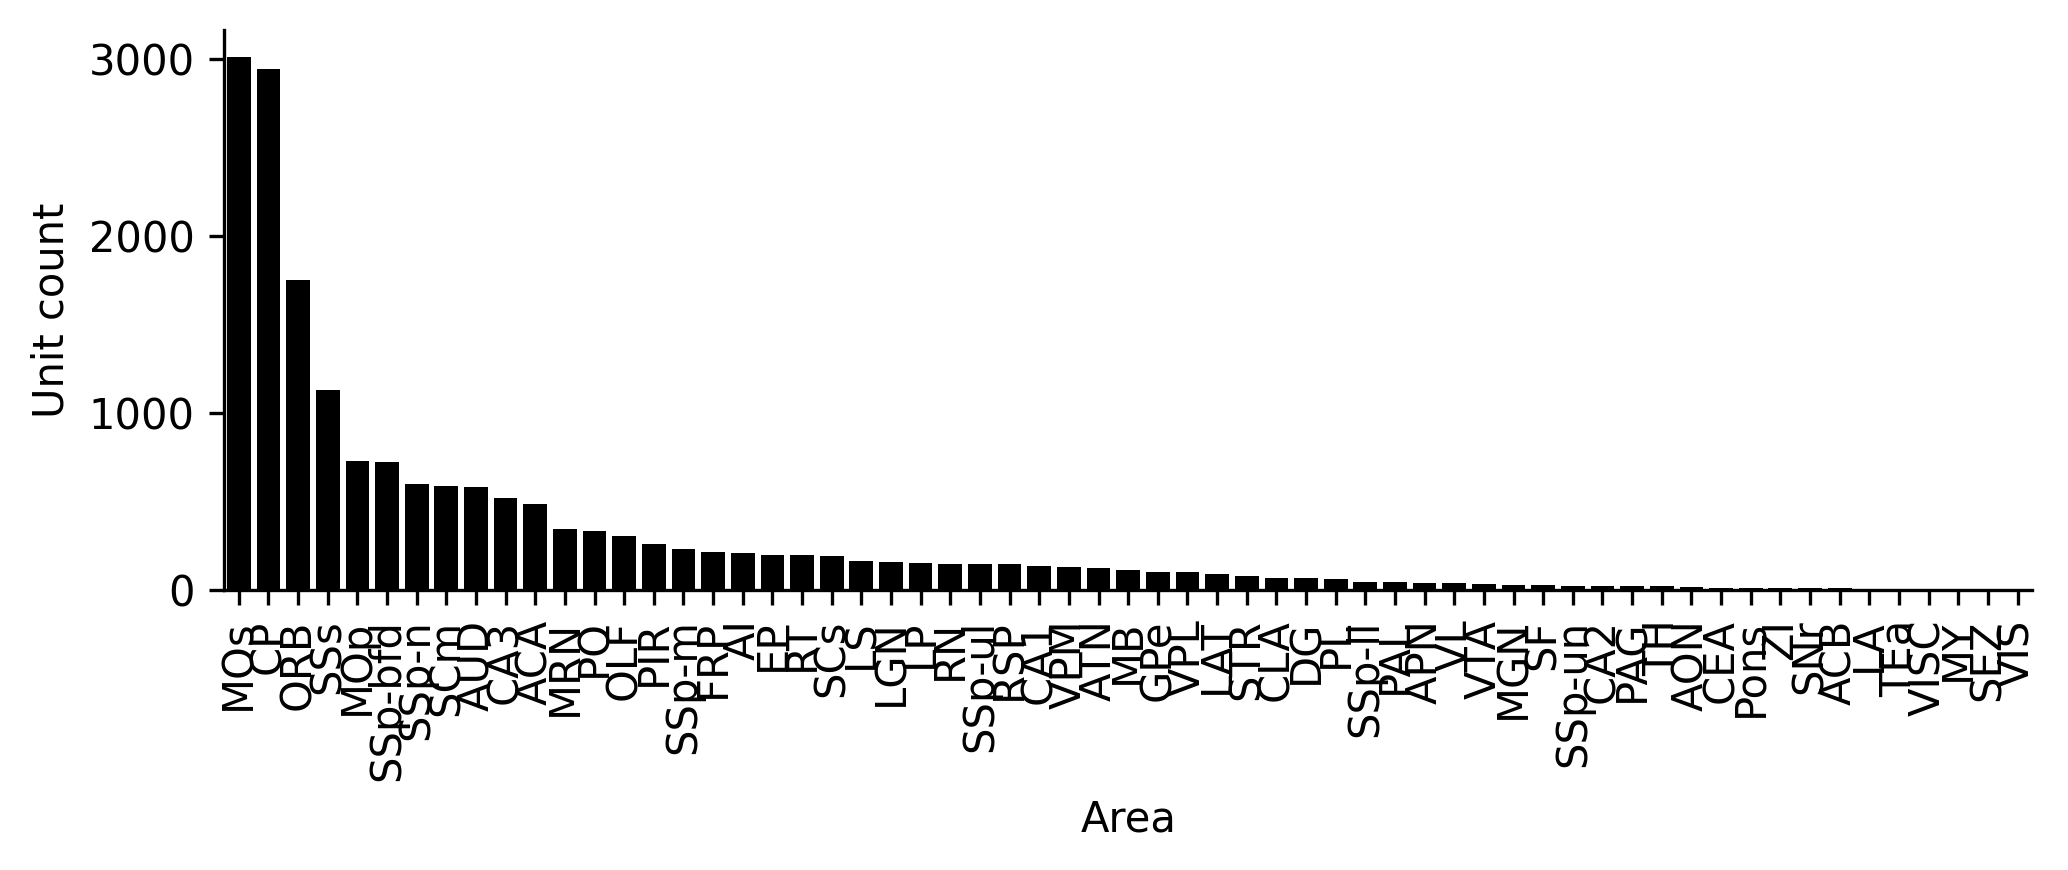

In [95]:
df_counts = roc_df.groupby(['analysis_type'])['area_acronym_custom'].value_counts().reset_index()
df_counts = df_counts[df_counts.analysis_type=='whisker_passive_post']
fig, ax = plt.subplots(1,1,figsize=(7,3),dpi=300)
sns.barplot(data=df_counts,
            ax=ax,
            x='area_acronym_custom',
            y='count',
            color='k')
sns.despine()
ax.set_xticks(labels=df_counts['area_acronym_custom'], ticks=ax.get_xticks(), rotation=90)
ax.set_ylabel('Unit count')
ax.set_xlabel('Area')
fig.tight_layout()
fname = 'roc_neuron_count_passivemice.png'
#fig.savefig(os.path.join(FIGURE_PATH, fname), bbox_inches='tight')

In [12]:
# Keep areas with at least N single units
N_UNITS_MIN = 10

# Count the number of occurrences per 'area_custom' grouped by 'analysis_type'
area_counts_by_analysis = roc_df.groupby(['analysis_type', 'area_acronym_custom']).size()

# Filter to retain only areas with counts above the threshold
valid_areas = area_counts_by_analysis[area_counts_by_analysis >= N_UNITS_MIN].index

# Subset the DataFrame to include only the valid areas
roc_df_subset = roc_df[roc_df.set_index(['analysis_type', 'area_acronym_custom']).index.isin(valid_areas)]

# Verify the counts in the subset
area_counts_subset = roc_df_subset.groupby(['analysis_type', 'area_acronym_custom']).size()
print(area_counts_subset)

# Find set of areas shared by R+ and R-
rplus_areas = roc_df_subset[roc_df_subset.reward_group=="R+"]['area_acronym_custom'].unique()
rmins_areas = roc_df_subset[roc_df_subset.reward_group=="R-"]['area_acronym_custom'].unique()
shared_areas = list(set(rplus_areas).intersection(rmins_areas))

n_rplus_areas = roc_df_subset[roc_df_subset.reward_group=="R+"]['area_acronym_custom'].nunique()
n_rmins_areas = roc_df_subset[roc_df_subset.reward_group=="R-"]['area_acronym_custom'].nunique()
print('Number of areas in R+:', n_rplus_areas, 'Number of areas in R-:', n_rmins_areas, 'Number of shared areas:', len(shared_areas))

rplus_areas_count = roc_df_subset[roc_df_subset.reward_group=="R+"]['area_acronym_custom'].value_counts()
rmins_areas_count = roc_df_subset[roc_df_subset.reward_group=="R-"]['area_acronym_custom'].value_counts()

print('Shared areas', shared_areas)
    

analysis_type                 area_acronym_custom
auditory_active               ACA                    882
                              ACB                     12
                              AI                     223
                              AON                     17
                              APN                     43
                                                    ... 
whisker_pre_vs_post_learning  VL                      43
                              VPL                    104
                              VPM                    133
                              VTA                     37
                              ZI                      14
Length: 727, dtype: int64
Number of areas in R+: 55 Number of areas in R-: 49 Number of shared areas: 46
Shared areas ['ORB', 'SF', 'RSP', 'SSp-ll', 'SSp-n', 'MRN', 'CA2', 'LS', 'STR', 'MOp', 'SSp-bfd', 'SSs', 'AUD', 'CA1', 'SCs', 'FRP', 'MOs', 'EP', 'PIR', 'APN', 'SSp-un', 'VIS', 'AI', 'PAG', 'LGN', 'TH', 'CP', 'CEA', 'Z

# Start with an example area
SSp-bfd

In [13]:
ex_area = 'SSp-bfd'
roc_df_single_area = roc_df_subset[roc_df_subset['area_acronym_custom'] == ex_area]
roc_df_single_area['mouse_id'].unique()

array(['AB085', 'AB087', 'AB092', 'AB093', 'AB102', 'AB116', 'AB117',
       'AB119', 'AB121', 'AB122', 'AB123', 'AB124', 'AB126', 'AB131',
       'AB136', 'AB142', 'AB145', 'AB147'], dtype=object)

In [75]:
roc_df_single_area.head(2)

,mouse_id,unit_id,cluster_id,firing_rate,ccf_acronym,ccf_name,ccf_parent_acronym,ccf_parent_id,ccf_parent_name,analysis_type,...,selectivity,fpr,tpr,thresholds,significant,direction,p_value,p_value_to_show,reward_group,area_custom
5340,AB085,297,86,5.429794,SSp-bfd6b,"Primary somatosensory area, barrel field, laye...",SSp-bfd,329.0,"Primary somatosensory area, barrel field",whisker_active,...,0.521366,[0. 0. 0.01351351 0.02702703 0...,[0. 0.02702703 0.06756757 0.12162162 0...,[inf 6. 5. 4. 3. 2. 1. 0.],True,positive,0.0,0.0,R-,SSp-bfd
5341,AB085,300,89,2.524369,SSp-bfd6a,"Primary somatosensory area, barrel field, laye...",SSp-bfd,329.0,"Primary somatosensory area, barrel field",whisker_active,...,0.616874,[0. 0. 0. 0. 0...,[0. 0.04054054 0.09459459 0.32432432 0...,[inf 4. 3. 2. 1. 0.],True,positive,0.0,0.0,R-,SSp-bfd


In [97]:
# Calculate the total neuron count per analysis type and per reward group
total_neurons_per_group = (
    roc_df_single_area.groupby(['analysis_type', 'reward_group'])
    .size()
    .reset_index(name='total_count')
)

# Group by direction and calculate selective counts
selective_counts = (
    roc_df_single_area[roc_df_single_area['significant']]  # Filter for selective neurons
    .groupby(['analysis_type', 'reward_group', 'direction'])
    .size()
    .reset_index(name='count')
)

# Add non-selective counts
non_selective_counts = (
    roc_df_single_area[~roc_df_single_area['significant']]  # Filter for non-selective neurons
    .groupby(['analysis_type', 'reward_group']) # no direction because assignment below
    .size()
    .reset_index(name='count')
)
non_selective_counts['direction'] = 'non-selective'

# Combine selective and non-selective counts
roc_df_single_area_perc = pd.concat([selective_counts, non_selective_counts], ignore_index=True)

# Merge total neuron counts
roc_df_single_area_perc = roc_df_single_area_perc.merge(total_neurons_per_group, on=['analysis_type', 'reward_group'])

# Calculate proportions
roc_df_single_area_perc['proportion'] = (roc_df_single_area_perc['count'] / roc_df_single_area_perc['total_count']) * 100
roc_df_single_area_perc.head(5)

,analysis_type,reward_group,direction,count,total_count,proportion
0,auditory_active,R+,negative,23,624,3.685897
1,auditory_active,R+,positive,57,624,9.134615
2,auditory_active,R-,negative,21,401,5.236908
3,auditory_active,R-,positive,62,401,15.461347
4,auditory_passive_post,R+,negative,12,368,3.260870


In [98]:
roc_df_single_area_perc[roc_df_single_area_perc.analysis_type=='auditory_passive_post']

,analysis_type,reward_group,direction,count,total_count,proportion
4,auditory_passive_post,R+,negative,12,368,3.260870
5,auditory_passive_post,R+,positive,14,368,3.804348
6,auditory_passive_post,R-,negative,7,240,2.916667
7,auditory_passive_post,R-,positive,16,240,6.666667
54,auditory_passive_post,R+,non-selective,342,368,92.934783
55,auditory_passive_post,R-,non-selective,217,240,90.416667


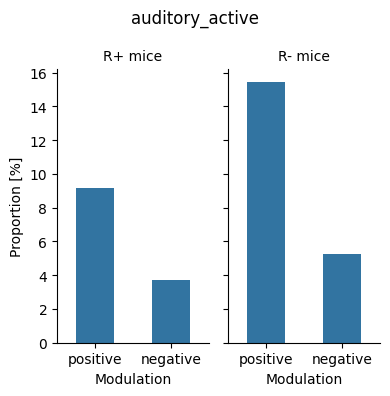

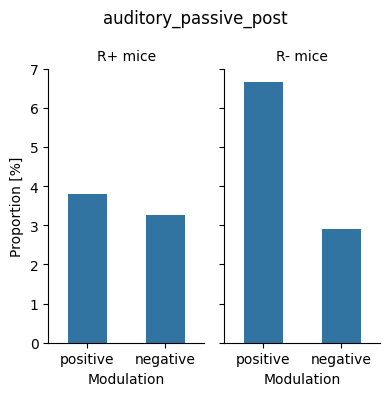

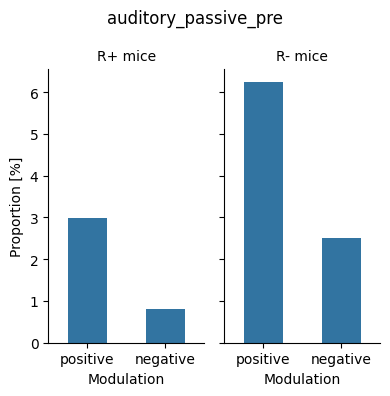

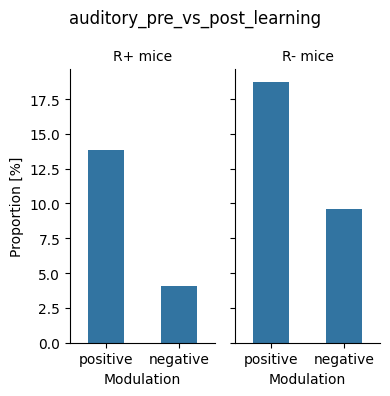

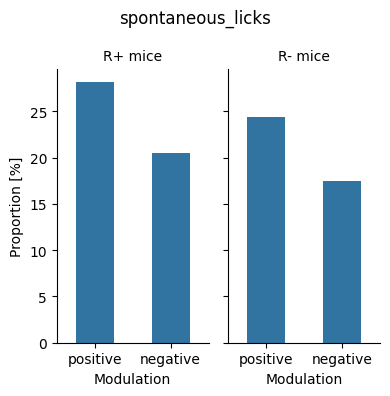

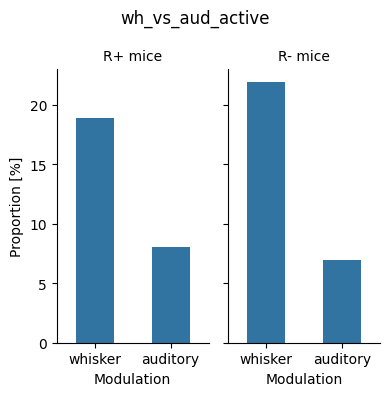

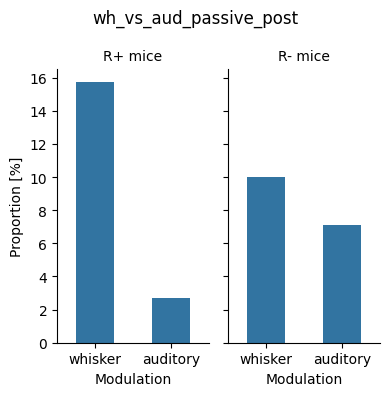

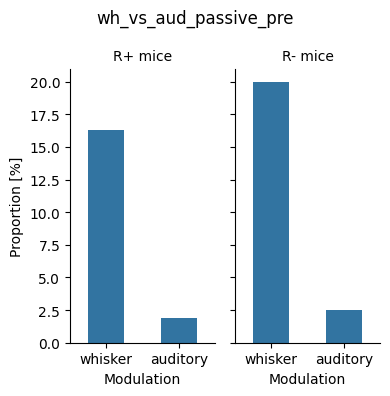

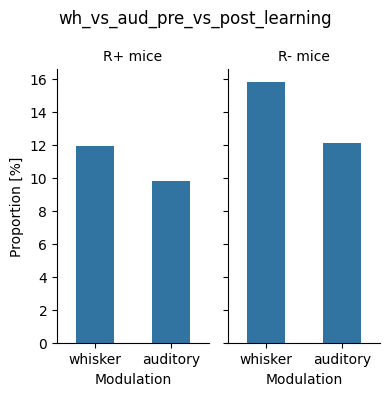

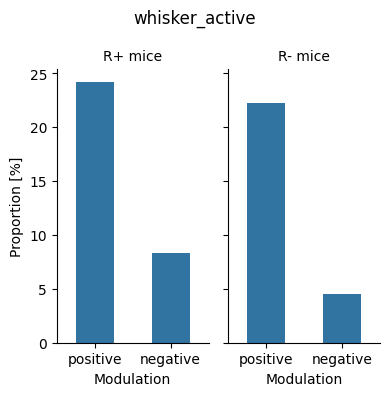

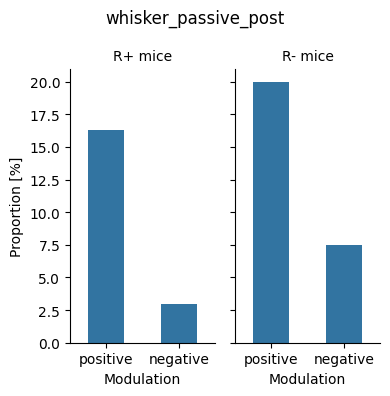

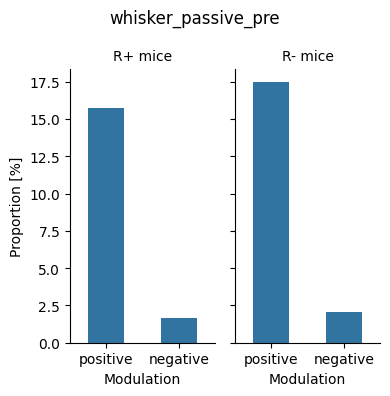

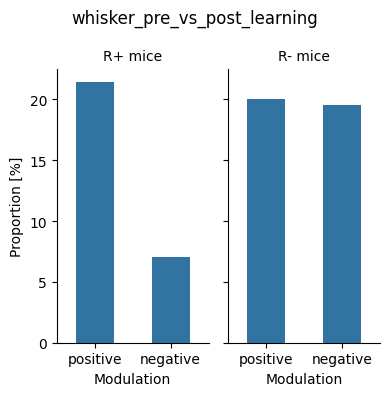

In [23]:
for anal_type in roc_df_single_area_perc['analysis_type'].unique():
    roc_prop_type = roc_df_single_area_perc[roc_df_single_area_perc['analysis_type']==anal_type]
    if 'wh_vs_aud' in anal_type:
        order = ['whisker','auditory']
    else:
        order=['positive', 'negative'] 
    g = sns.FacetGrid(roc_prop_type, col='reward_group', sharey=True, despine=True,height=4, aspect=.5)
    g.map(sns.barplot, 'direction', "proportion", order=order, dodge=True, width=0.5)
    g.figure.suptitle(anal_type)
    g.set_axis_labels('Modulation', 'Proportion [%]')
    g.set_titles(col_template="{col_name} mice")
    g.tight_layout()


    fname = f'{ex_area}_{anal_type}_direction.png'
    #g.savefig(os.path.join(FIGURE_PATH, fname))

C:\Users\bisi\AppData\Roaming\Python\Python310\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\bisi\AppData\Roaming\Python\Python310\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\bisi\AppData\Roaming\Python\Python310\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\bisi\AppDa

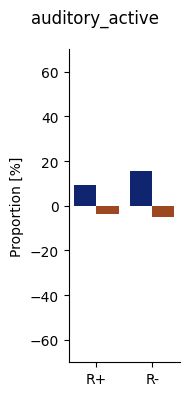

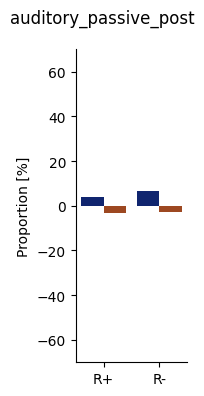

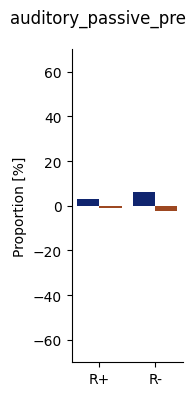

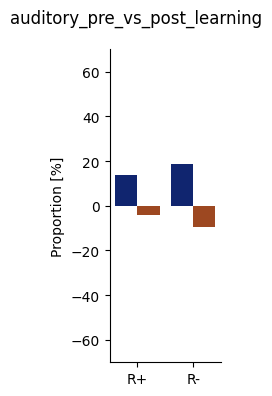

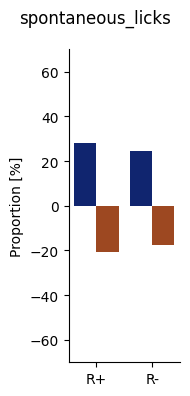

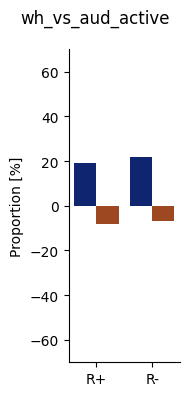

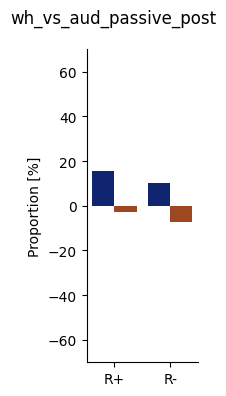

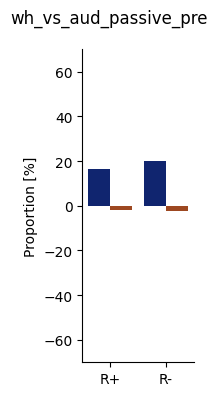

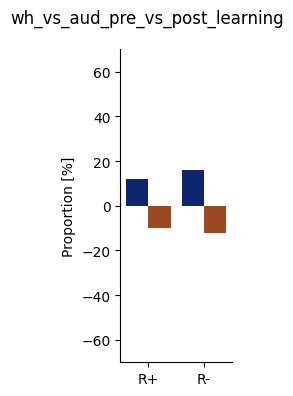

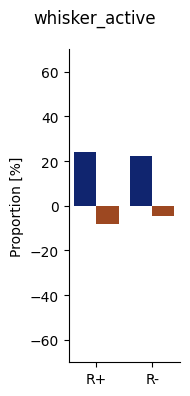

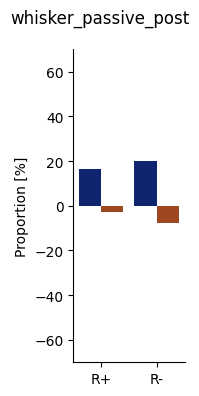

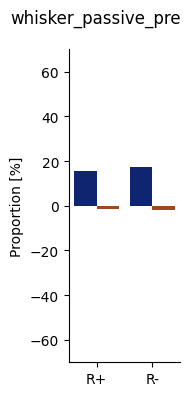

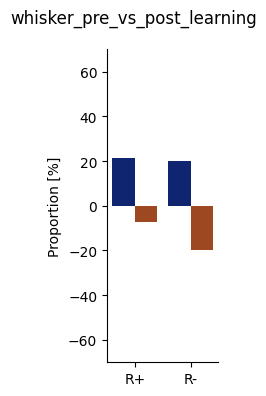

In [24]:
# Make a double sided plot - invert the sign for negative and auditory directions
roc_df_single_area_perc['proportion_signed'] = roc_df_single_area_perc['proportion']
roc_df_single_area_perc.loc[roc_df_single_area_perc.direction.eq('negative'), 'proportion_signed'] = (-1)*roc_df_single_area_perc.loc[roc_df_single_area_perc.direction.eq('negative'), 'proportion']
roc_df_single_area_perc.loc[roc_df_single_area_perc.direction.eq('auditory'), 'proportion_signed'] = (-1)*roc_df_single_area_perc.loc[roc_df_single_area_perc.direction.eq('auditory'), 'proportion']

for anal_type in roc_df_single_area_perc['analysis_type'].unique():
    roc_prop_type = roc_df_single_area_perc[roc_df_single_area_perc['analysis_type']==anal_type]
   
    if 'wh_vs_aud' in anal_type:
        order = ['whisker','auditory']
    else:
        order=['positive', 'negative'] 

    g = sns.catplot(
        data=roc_prop_type, 
        kind='bar',
        x='reward_group',
        y='proportion_signed',
        order=['R+','R-'], 
        hue='direction',
        hue_order=order,
        errorbar=None, 
        palette='dark', 
        height=4,
        aspect=0.5,
        legend=False
    )
    g.figure.suptitle(anal_type)
    g.despine(left=False)
    g.set_axis_labels('', 'Proportion [%]')
    g.set_titles(col_template="{col_name} mice")
    g.set(ylim=(-70, 70))
    g.tight_layout()

    fname = f'{ex_area}_{anal_type}_direction_signed.png'
    #g.savefig(os.path.join(FIGURE_PATH, fname))

# Figures for all areas
#### First, create a customized area order, with associated colros

In [24]:
roc_df_shared_areas = roc_df_subset
roc_df_shared_areas['area_acronym_custom'].unique()
area_order = allen.get_custom_area_order()

# List all areas present vs area order list
missing = [a for a in shared_areas if a not in area_order]
area_order_shared = [a for a in area_order if a in shared_areas]

# Make a color dict for the group of areas
area_groups = allen.get_custom_area_groups()

# Keep areas that present in dataset
area_groups = {k: [i for i in v if i in area_order_shared] for k,v in area_groups.items()}
print(area_groups, len(area_groups.keys()))

# Generate a colormap with as many colors as the number of area groups
color_palette = plt.cm.tab20.colors  # Use the tab20 colormap for distinct colors
color_palette = ['#1f9d5a', '#188064', '#019399', '#1aa698', '#8ada87', '#7ed04b', '#98d6f9', '#ff7080', '#ff64ff', '#9ad2bd', '#f2483b']
color_palette_dict = allen.get_custom_area_groups_colors()
color_palette = list(color_palette_dict.values())




#colors = [[color] * len(list(area_groups.keys())[idx]) for idx,color in enumerate(color_palette)]
#colors = [x for xs in colors for x in xs]
#colors = [mc.rgb2hex(color_palette[i % len(color_palette)]) for i in range(len(area_groups))]
colors = [color_palette[i % len(color_palette)] for i in range(len(area_groups))] #hex
#colors = [mc.hex2color(color_palette[i % len(color_palette)]) for i in range(len(area_groups))] #rgb
print('Equality ensured', len(colors)==len(area_groups.keys()))

# Create a dictionary mapping each area to its group color
area_color_dict = {}
#area_color_dict = allen.get_custom_area_groups_colors()
for (group_name, areas), color in zip(area_groups.items(), colors):
    for area in areas:
        area_color_dict[area] = color
area_color_list = list(area_color_dict.values())


{'Motor and frontal areas': ['MOp', 'MOs', 'FRP', 'ACA', 'ORB', 'AI'], 'Somatosensory areas': ['SSp-bfd', 'SSs', 'SSp-m', 'SSp-n', 'SSp-ul', 'SSp-ll', 'SSp-un'], 'Auditory areas': ['AUD'], 'Retrosplenial areas': ['RSP'], 'Cortical subplate': ['EP'], 'Hippocampus': ['CA1', 'CA2', 'CA3'], 'Striatal and pallidum': ['CP', 'STR', 'CEA', 'LS', 'SF', 'GPe', 'PAL'], 'Thalamus': ['VPL', 'VPM', 'RT', 'PO', 'LGN', 'ATN'], 'Midbrain': ['SCs', 'SCm', 'MB', 'VTA', 'MRN', 'PAG', 'RN'], 'Pons': [], 'Olfactory areas': ['OLF', 'PIR'], 'Hypothalamus': ['ZI']} 12
Equality ensured True


In [25]:
print('colors', colors)
print('dict', area_color_list, len(area_color_list))
print(area_order_shared, len(area_order_shared))

colors ['#1f9d5a', '#188064', '#019399', '#1aa698', '#8ada87', '#7ed04b', '#98d6f9', '#ff7080', '#ff64ff', '#ffc395', '#9ad2bd', '#f2483b']
dict ['#1f9d5a', '#1f9d5a', '#1f9d5a', '#1f9d5a', '#1f9d5a', '#1f9d5a', '#188064', '#188064', '#188064', '#188064', '#188064', '#188064', '#188064', '#019399', '#1aa698', '#8ada87', '#7ed04b', '#7ed04b', '#7ed04b', '#98d6f9', '#98d6f9', '#98d6f9', '#98d6f9', '#98d6f9', '#98d6f9', '#98d6f9', '#ff7080', '#ff7080', '#ff7080', '#ff7080', '#ff7080', '#ff7080', '#ff64ff', '#ff64ff', '#ff64ff', '#ff64ff', '#ff64ff', '#ff64ff', '#ff64ff', '#9ad2bd', '#9ad2bd', '#f2483b'] 42
['MOp', 'MOs', 'FRP', 'ACA', 'ORB', 'AI', 'SSp-bfd', 'SSs', 'SSp-m', 'SSp-n', 'SSp-ul', 'SSp-ll', 'SSp-un', 'AUD', 'RSP', 'EP', 'CA1', 'CA2', 'CA3', 'CP', 'STR', 'CEA', 'LS', 'SF', 'GPe', 'PAL', 'VPL', 'VPM', 'RT', 'PO', 'LGN', 'ATN', 'SCs', 'SCm', 'MB', 'VTA', 'MRN', 'PAG', 'RN', 'OLF', 'PIR', 'ZI'] 42


#### Compute proportion per area

In [26]:
# Calculate the total neuron count per analysis type and per reward group
total_neurons_per_group = (
    roc_df_shared_areas.groupby(['analysis_type', 'reward_group', 'area_acronym_custom'])
    .size()
    .reset_index(name='total_count')
)

# Group by direction and calculate selective counts
selective_counts = (
    roc_df_shared_areas[roc_df_shared_areas['significant']]  # Filter for selective neurons
    .groupby(['analysis_type', 'reward_group', 'area_acronym_custom', 'direction'])
    .size()
    .reset_index(name='count')
)

# Add non-selective counts
non_selective_counts = (
    roc_df_shared_areas[~roc_df_shared_areas['significant']]  # Filter for non-selective neurons
    .groupby(['analysis_type', 'reward_group', 'area_acronym_custom']) # no direction because assignment below
    .size()
    .reset_index(name='count')
)
non_selective_counts['direction'] = 'non-selective'

# Combine selective and non-selective counts
roc_df_shared_areas_perc = pd.concat([selective_counts, non_selective_counts], ignore_index=True)

# Merge total neuron counts
roc_df_shared_areas_perc = roc_df_shared_areas_perc.merge(total_neurons_per_group, on=['analysis_type', 'reward_group', 'area_acronym_custom'])

# Calculate proportions
roc_df_shared_areas_perc['proportion'] = (roc_df_shared_areas_perc['count'] / roc_df_shared_areas_perc['total_count']) * 100
roc_df_shared_areas_perc.head(5)

,analysis_type,reward_group,area_acronym_custom,direction,count,total_count,proportion
0,auditory_active,R+,ACA,negative,30,336,8.928571
1,auditory_active,R+,ACA,positive,83,336,24.702381
2,auditory_active,R+,AI,negative,3,208,1.442308
3,auditory_active,R+,AI,positive,36,208,17.307692
4,auditory_active,R+,AON,positive,1,17,5.882353


In [27]:
# Make a double sided plot - invert the sign for negative and auditory directions
roc_df_shared_areas_perc['proportion_signed'] = roc_df_shared_areas_perc['proportion']
roc_df_shared_areas_perc.loc[roc_df_shared_areas_perc.direction.eq('negative'), 'proportion_signed'] = (-1)*roc_df_shared_areas_perc.loc[roc_df_shared_areas_perc.direction.eq('negative'), 'proportion']
roc_df_shared_areas_perc.loc[roc_df_shared_areas_perc.direction.eq('auditory'), 'proportion_signed'] = (-1)*roc_df_shared_areas_perc.loc[roc_df_shared_areas_perc.direction.eq('auditory'), 'proportion']


In [28]:
len(area_color_list)

42

#### Make figure one group

C:\Users\bisi\AppData\Local\Temp\ipykernel_19668\2236995100.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\bisi\AppData\Roaming\Python\Python310\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\bisi\AppData\Roaming\Python\Python310\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\bisi\AppData\Roaming\Python\Python310\site-packages\seaborn\_base.py

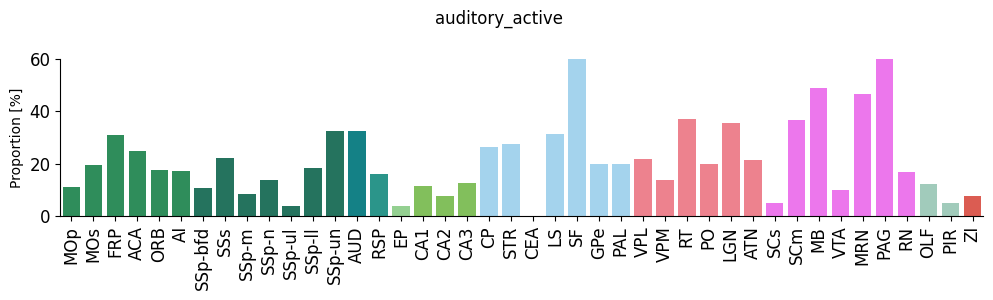

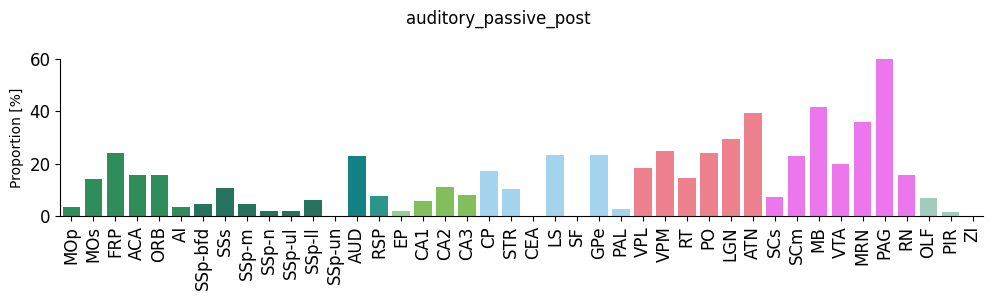

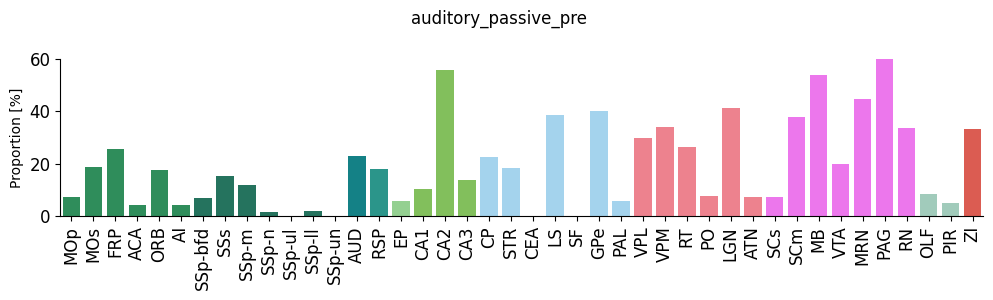

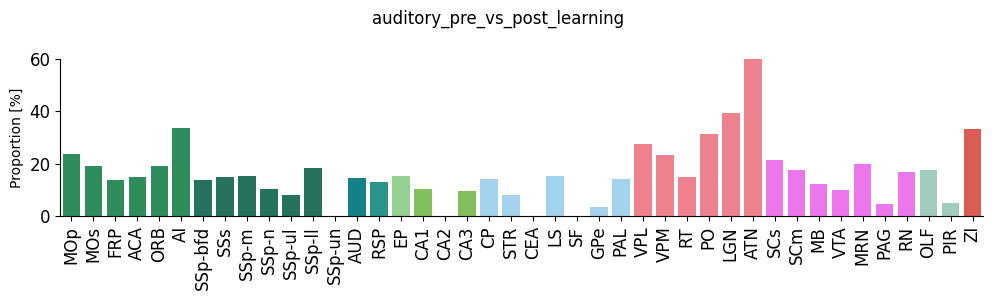

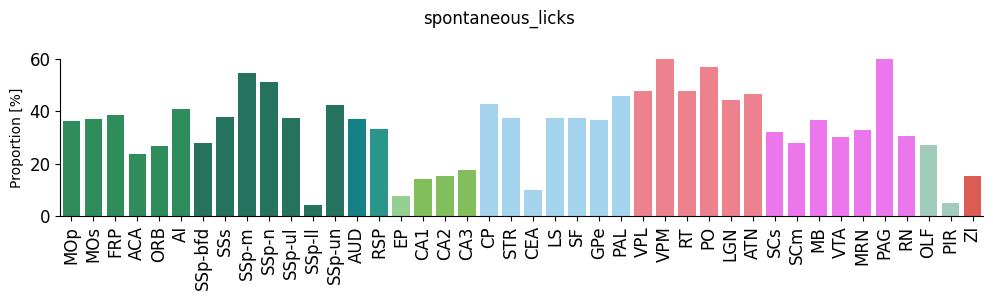

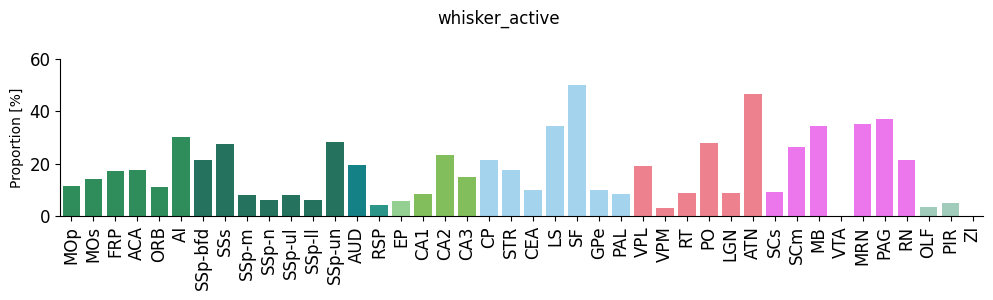

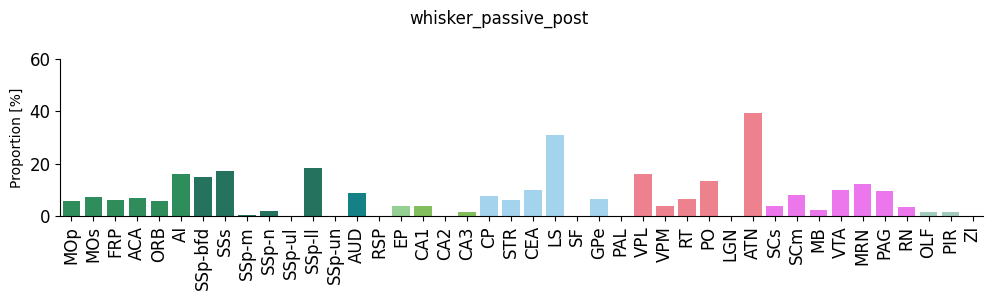

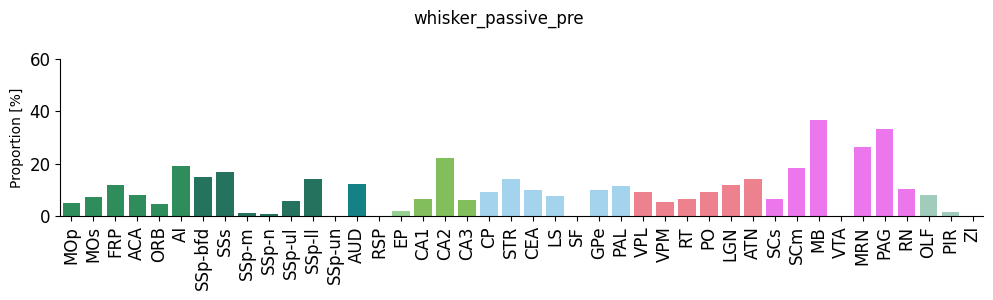

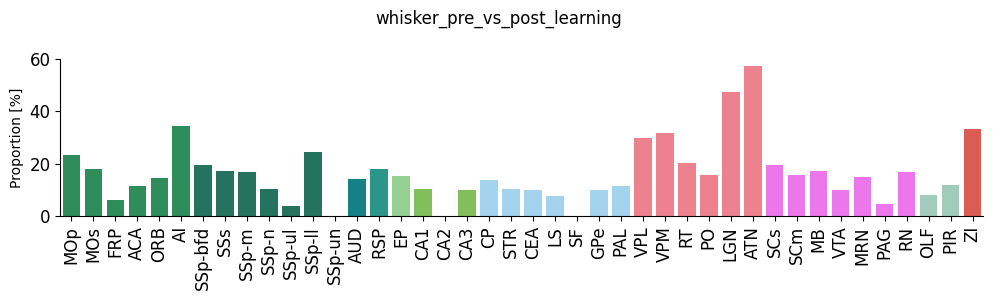

In [29]:
# Keep R+ rewarded mice only for now
roc_df_shared_areas_perc_rewarded = roc_df_shared_areas_perc[roc_df_shared_areas_perc.reward_group.eq('R+')]
roc_df_shared_areas_perc_rewarded = roc_df_shared_areas_perc_rewarded[roc_df_shared_areas_perc_rewarded.direction.eq('positive')]

for anal_type in roc_df_shared_areas_perc_rewarded['analysis_type'].unique():
    #fig, ax = plt.subplots(1, 1, figsize=(7, 5), sharex=True)
    roc_df_all_areas_type = roc_df_shared_areas_perc_rewarded[roc_df_shared_areas_perc_rewarded['analysis_type']==anal_type]
    
    if 'wh_vs_aud' in anal_type:
        order = ['whisker','auditory']
        suffix = 'auditory'
    else:
        order=['positive', 'negative'] 
        suffix = 'positive'
    g = sns.catplot(
        data=roc_df_all_areas_type, 
        kind='bar',
        x='area_acronym_custom',
        y='proportion_signed',
        order=area_order_shared, 
        palette=area_color_list,
        #color=area_color_list,
        #row='direction',
        #hue_order=order,
        height=2.5,
        aspect=4,
        errorbar=None, 
        legend=False
    )
    g.figure.suptitle(anal_type)
    g.despine(left=False)
    g.set_axis_labels('', 'Proportion [%]')
    g.set(ylim=(0, 60))
    g.tight_layout()
    g.set_xticklabels(rotation=90)
    g.tick_params(labelsize=12)
    
    figname = f'brainwide_roc_rplus_{anal_type}_{suffix}.svg'
    g.savefig(os.path.join(FIGURE_PATH, figname))
    
    

In [121]:
len(area_order_shared)

42

In [119]:
roc_df_all_areas_type['area_acronym_custom'].nunique()

50

In [60]:
roc_df_all_areas_type[roc_df_all_areas_type.area_custom=='LS']

,analysis_type,reward_group,area_custom,direction,count,total_count,proportion,proportion_signed
2339,whisker_pre_vs_post_learning,R-,LS,positive,13,155,8.387097,8.387097


#### Make figure both groups

C:\Users\bisi\AppData\Roaming\Python\Python310\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\bisi\AppData\Roaming\Python\Python310\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\bisi\AppData\Roaming\Python\Python310\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\bisi\AppDa

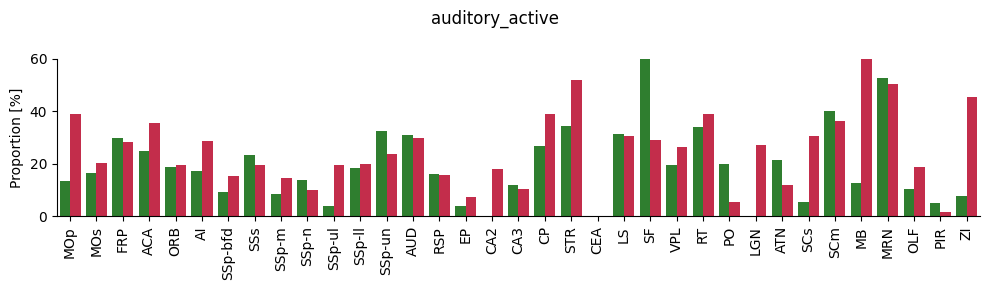

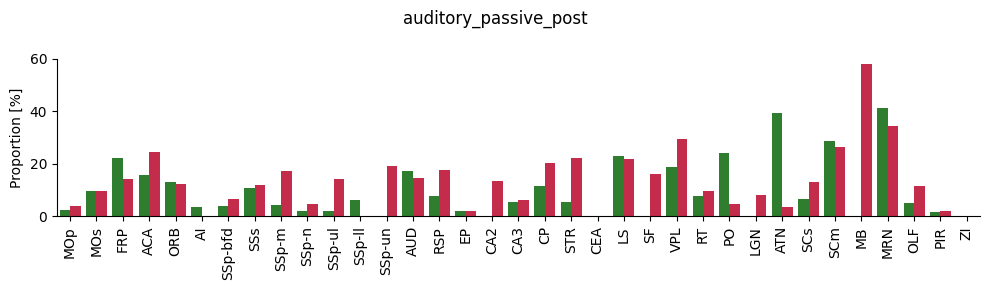

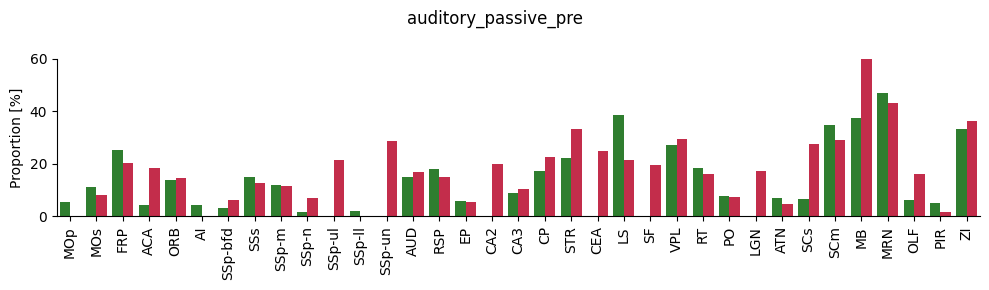

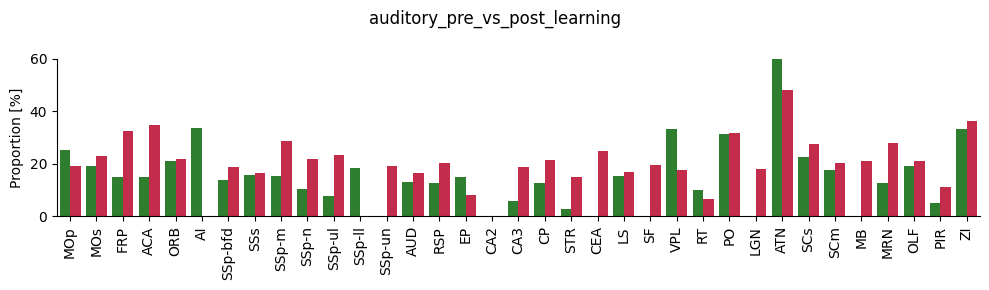

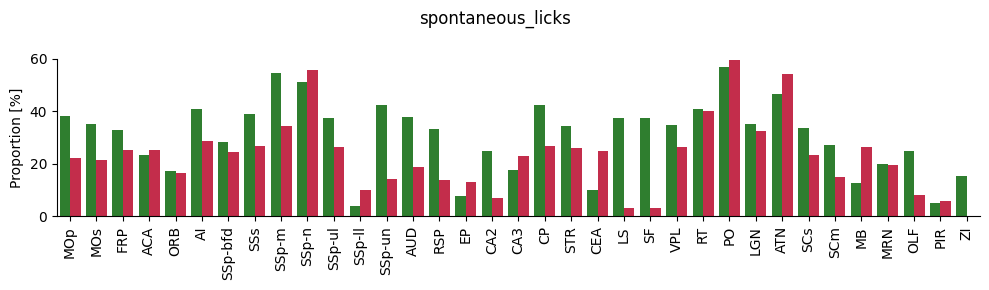

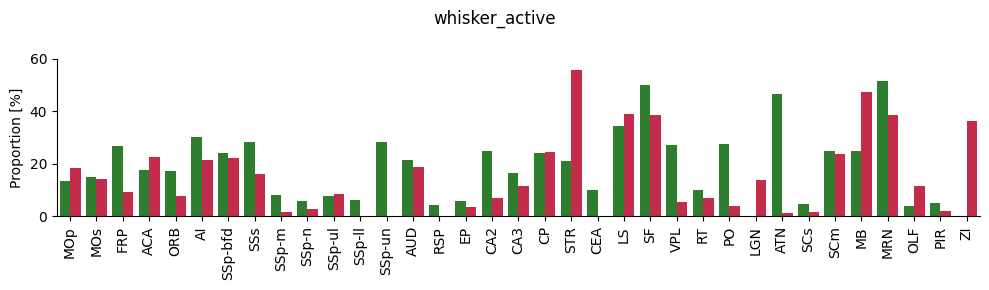

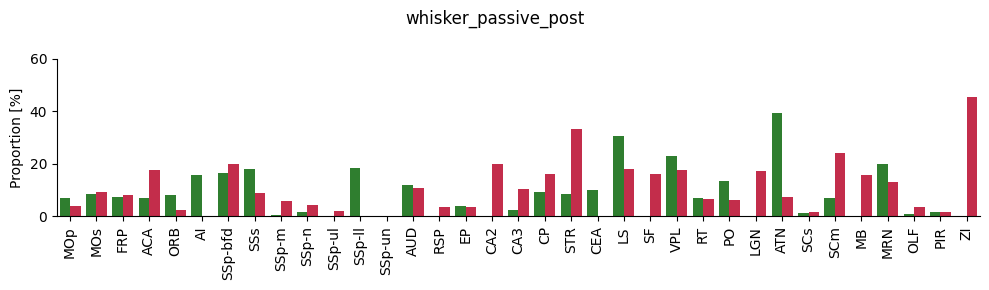

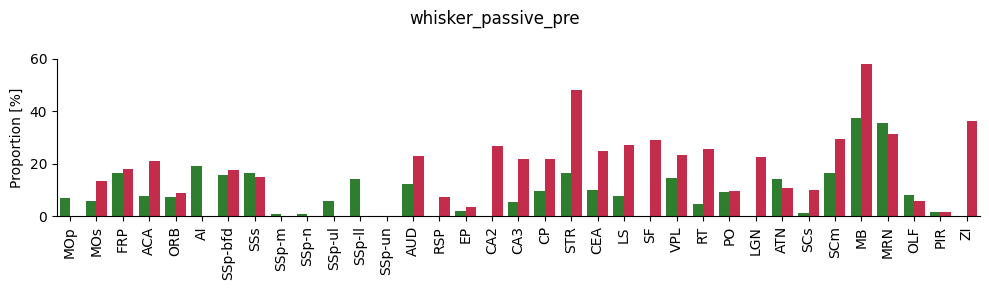

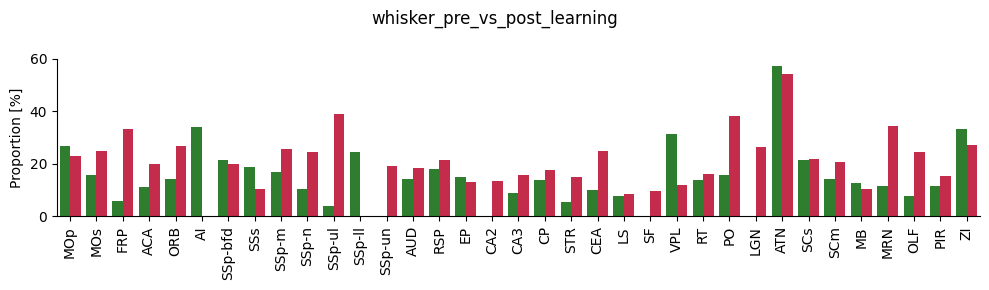

In [35]:
roc_df_shared_areas_perc_both = roc_df_shared_areas_perc[roc_df_shared_areas_perc.direction.eq('positive')]

for anal_type in roc_df_shared_areas_perc_both['analysis_type'].unique():
    #fig, ax = plt.subplots(1, 1, figsize=(7, 5), sharex=True)
    roc_df_all_areas_type = roc_df_shared_areas_perc_both[roc_df_shared_areas_perc_both['analysis_type']==anal_type]
    
    if 'wh_vs_aud' in anal_type:
        order = ['whisker','auditory']
        suffix = 'auditory'
    else:
        order=['positive', 'negative'] 
        suffix = 'positive'
    g = sns.catplot(
        data=roc_df_all_areas_type, 
        kind='bar',
        x='area_acronym_custom',
        y='proportion_signed',
        order=area_order_shared, 
        palette=['forestgreen','crimson'],
        #color=area_color_list,
        #row='direction',
        hue='reward_group',
        hue_order=['R+','R-'],
        height=2.5,
        aspect=4,
        errorbar=None, 
        legend=False
    )
    g.figure.suptitle(anal_type)
    g.despine(left=False)
    g.set_axis_labels('', 'Proportion [%]')
    g.set(ylim=(0, 60))
    g.tight_layout()
    g.set_xticklabels(rotation=90)
    
    figname = f'brainwide_roc_reward_groups_{anal_type}_{suffix}.svg'
    g.savefig(os.path.join(FIGURE_PATH, figname))
    
    

#### Make a legend figure

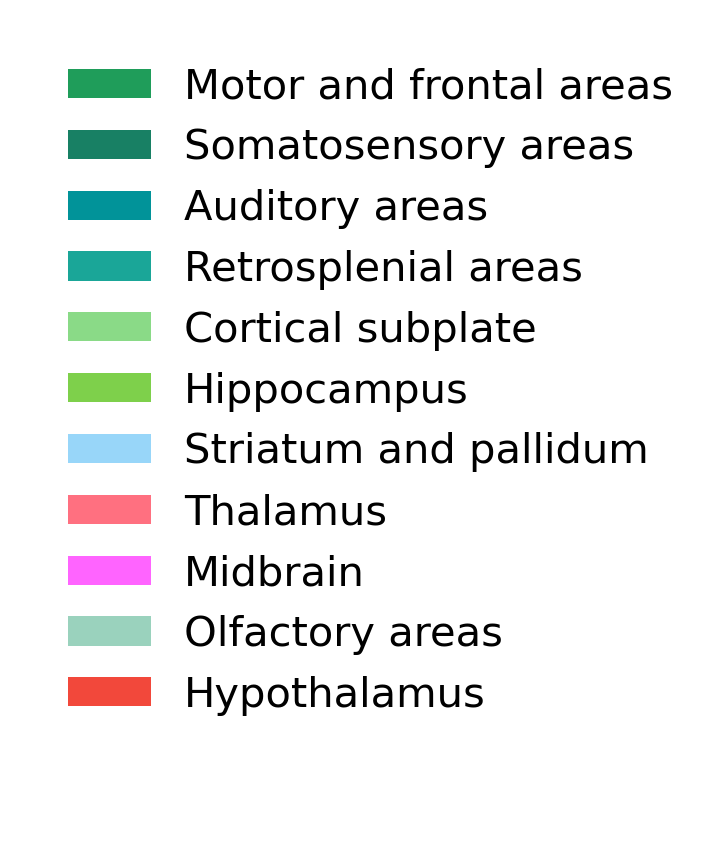

In [330]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def create_legend_figure(color_dict, rectangles=True, title="Legend"):
    """
    Create a legend figure from a dictionary mapping strings to colors.

    Parameters:
        color_dict (dict): A dictionary mapping strings to colors (e.g., {"Label": "#ff0000"}).
        rectangles (bool): If True, use colored rectangles; otherwise, color the text directly.
        title (str): Title for the legend figure.

    Returns:
        matplotlib.figure.Figure: A figure containing the legend.
    """
    fig, ax = plt.subplots(figsize=(2,3), dpi=300)
    ax.axis('off')  # Turn off the axes for a cleaner look   

    legend_elements = [Patch(facecolor=color, label=label) for label, color in color_dict.items()]
    ax.legend(handles=legend_elements, loc='upper left', frameon=False, title=title)
    
    return fig

area_groups = {
    'Motor and frontal areas': ['MOp', 'MOs', 'FRP', 'ACA', 'PL', 'ORB', 'AI'],
    'Somatosensory areas': ['SSp-bfd', 'SSs', 'SSp-m', 'SSp-n', 'SSp-ul', 'SSp-ll', 'SSp-tr', 'SSp-un'],
    'Auditory areas': ['AUD'],
    'Retrosplenial areas': ['RSP'],
    'Cortical subplate': ['CLA', 'EP'],
    'Hippocampus': ['CA1', 'CA2', 'CA3'],
    'Striatal and pallidum': ['CP', 'STR', 'ACB', 'CEA', 'LS', 'SF', 'GPe', 'PAL', 'MS'],
    'Thalamus': ['VPL', 'VPM', 'AV', 'LD', 'RT', 'PO', 'LGN'],
    'Midbrain': ['MRN', 'PAG', 'SCs', 'SCm'],
    'Olfactory areas': ['AON', 'OLF', 'PIR'],
    'Hypothalamus': ['ZI']
}

color_dict_legend = {
    'Motor and frontal areas': '#1f9d5a',
    'Somatosensory areas': '#188064',
    'Auditory areas': '#019399',
    'Retrosplenial areas': '#1aa698',
    'Cortical subplate': '#8ada87',
    'Hippocampus': '#7ed04b',
    'Striatum and pallidum': '#98d6f9',
    'Thalamus': '#ff7080',
    'Midbrain': '#ff64ff',
    'Olfactory areas': '#9ad2bd',
    'Hypothalamus': '#f2483b'
}
color_palette = ['#1f9d5a', '#188064', '#019399', '#1aa698', '#8ada87', '#7ed04b', '#98d6f9', '#ff7080', '#ff64ff', '#9ad2bd', '#f2483b']


# Generate legend figure with rectangles
fig = create_legend_figure(color_dict_legend, rectangles=True, title='')
fig.tight_layout()
plt.show()
figname = 'allen_area_group_legend.png'
fig.savefig(os.path.join(FIGURE_PATH, figname), dpi=300, bbox_inches='tight')
figname = 'allen_area_group_legend.svg'
fig.savefig(os.path.join(FIGURE_PATH, figname), dpi=300, bbox_inches='tight')


# Compare before and after learning
#### Average number of selective units, pre vs post

C:\Users\bisi\AppData\Local\Temp\ipykernel_19668\1932245068.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roc_df_npre['direction'] = roc_df_npre['direction'].replace({'positive': 'both', 'negative': 'both'}) # replace cat name to 'both'
C:\Users\bisi\AppData\Local\Temp\ipykernel_19668\1932245068.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roc_df_nact['direction'] = roc_df_nact['direction'].replace({'positive': 'both', 'negative': 'both'}) # replace cat name to 'both'
C:\Users\bisi\AppData\Loc

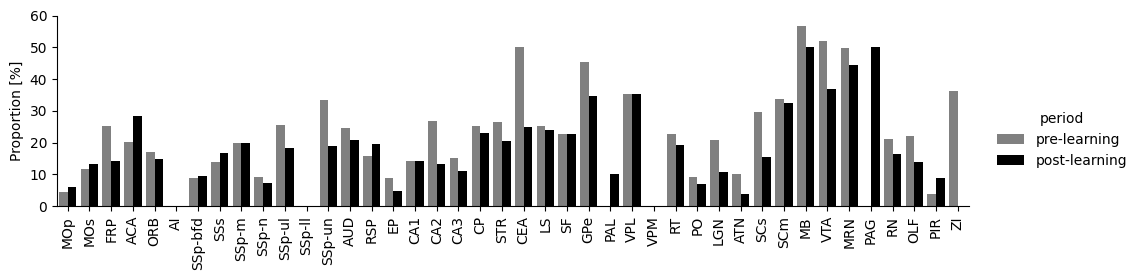

In [33]:
reward_group = 'R-'
stim_type = 'auditory'
roc_df_shared_areas_perc_both_direction = roc_df_shared_areas_perc[roc_df_shared_areas_perc.reward_group.eq(reward_group)]

# Pre learning ROC results
roc_df_npre = roc_df_shared_areas_perc_both_direction[roc_df_shared_areas_perc_both_direction.analysis_type=='{}_passive_pre'.format(stim_type)]
roc_df_npre['direction'] = roc_df_npre['direction'].replace({'positive': 'both', 'negative': 'both'}) # replace cat name to 'both'
roc_df_npre = roc_df_npre.groupby(['analysis_type','reward_group','area_acronym_custom','direction'], as_index=False)['proportion'].sum() # sum 'both' values
roc_df_npre['period'] = 'pre-learning'

# Active learning ROC results
roc_df_nact = roc_df_shared_areas_perc_both_direction[roc_df_shared_areas_perc_both_direction.analysis_type=='{}_active'.format(stim_type)]
roc_df_nact['direction'] = roc_df_nact['direction'].replace({'positive': 'both', 'negative': 'both'}) # replace cat name to 'both'
roc_df_nact = roc_df_nact.groupby(['analysis_type','reward_group','area_acronym_custom','direction'], as_index=False)['proportion'].sum() # sum 'both' values
roc_df_nact['period'] = 'active'

# Post learning ROC results
roc_df_npost = roc_df_shared_areas_perc_both_direction[roc_df_shared_areas_perc_both_direction.analysis_type=='{}_passive_post'.format(stim_type)]
roc_df_npost['direction'] = roc_df_npost['direction'].replace({'positive': 'both', 'negative': 'both'}) # replace cat name to 'both'
roc_df_npost = roc_df_npost.groupby(['analysis_type','reward_group','area_acronym_custom','direction'], as_index=False)['proportion'].sum() # sum 'both' values
roc_df_npost['period'] = 'post-learning'

# Combine
roc_pre_vs_post_df = pd.concat([roc_df_npre, roc_df_nact, roc_df_npost])
roc_pre_vs_post_df.reset_index(inplace=True)

# Plot pre. vs post
df = roc_pre_vs_post_df[roc_pre_vs_post_df.direction=='both']
g = sns.catplot(
    data=df, 
    kind='bar',
    x='area_acronym_custom',
    y='proportion',
    order=area_order_shared, 
    hue='period',
    hue_order=['pre-learning','post-learning'],
    palette=['grey','k'],
    height=2.5,
    aspect=4,
    errorbar=None, 
    legend=True,
    legend_out=True,
    seed=42
)
g.despine(left=False)
g.set_axis_labels('', 'Proportion [%]')
g.set(ylim=(0, 60))
g.tight_layout()
g.set_xticklabels(rotation=90)

if reward_group == 'R+':
    reward_suffix = 'rplus'
else:
    reward_suffix = 'rminus'

from scipy.stats import chi2_contingency

for area in df['area_acronym_custom'].unique():
    try:
        cond1_prop = df[(df.area_custom==area)&(df.analysis_type=='whisker_passive_pre')]['proportion'].values[0]
        cond2_prop = df[(df.area_custom==area)&(df.analysis_type=='whisker_passive_post')]['proportion'].values[0]
    except:
        continue
        
    contingency_table = np.array([
        [cond1_prop, 100-cond1_prop],
        [cond2_prop, 100-cond2_prop]
    ])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    #if p_value < 0.05:
    print(area, '- Chi-sq. statistic', chi2, 'p-value', p_value, 'dof', dof, 'expected frequencies:', expected)

figname = f'brainwide_roc_{reward_suffix}_npre_vs_npost_{stim_type}.svg'
g.savefig(os.path.join(FIGURE_PATH, figname))

#### Number of units that are became selective post-learning vs. pre-learning

C:\Users\bisi\AppData\Roaming\Python\Python310\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\bisi\AppData\Roaming\Python\Python310\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


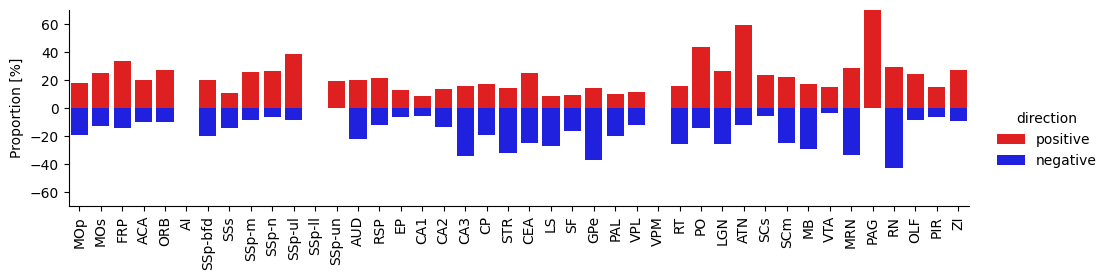

In [43]:
reward_group = 'R-'
stim_type = 'whisker'
roc_df_shared_areas_perc_prepost = roc_df_shared_areas_perc[(roc_df_shared_areas_perc.reward_group.eq(reward_group)) 
                                & (roc_df_shared_areas_perc.analysis_type.eq(f'{stim_type}_pre_vs_post_learning'))]

# Plot pre. vs post
g = sns.catplot(
    data=roc_df_shared_areas_perc_prepost, 
    kind='bar',
    x='area_acronym_custom',
    y='proportion_signed',
    order=area_order_shared, 
    hue='direction',
    hue_order=['positive','negative'],
    palette=['red','blue'],
    height=2.5,
    aspect=4,
    errorbar=None, 
    legend=True,
    legend_out=True,
    dodge=False
)
g.despine(left=False)
g.set_axis_labels('', 'Proportion [%]')
g.set(ylim=(-70, 70))
g.tight_layout()
g.set_xticklabels(rotation=90)

if reward_group == 'R+':
    reward_suffix = 'rplus'
else:
    reward_suffix = 'rminus'

figname = f'brainwide_roc_{reward_suffix}_across_learning_{stim_type}.svg'
g.savefig(os.path.join(FIGURE_PATH, figname))

#